In [90]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
%load_ext tensorboard

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import datetime, os


import io
import itertools
from packaging import version


from tensorflow import keras
from tensorflow.keras import models

from PIL.Image import *
import urllib.request

import numpy as np
import sklearn.metrics

print(tf.__version__)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.4.0


In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 1000 files belonging to 2 classes.


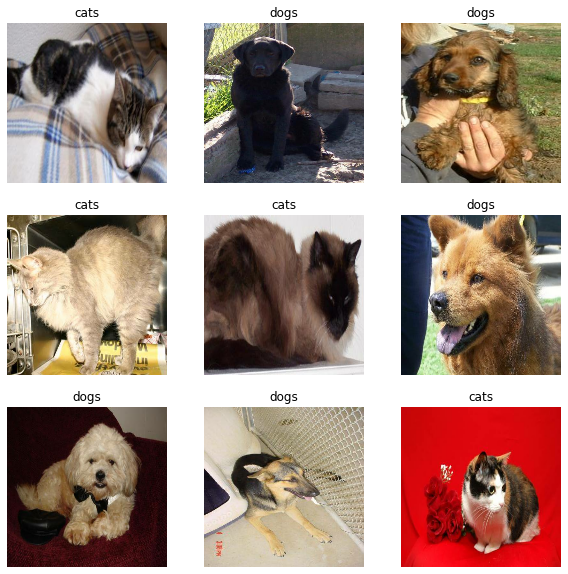

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 26
Number of test batches: 6


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


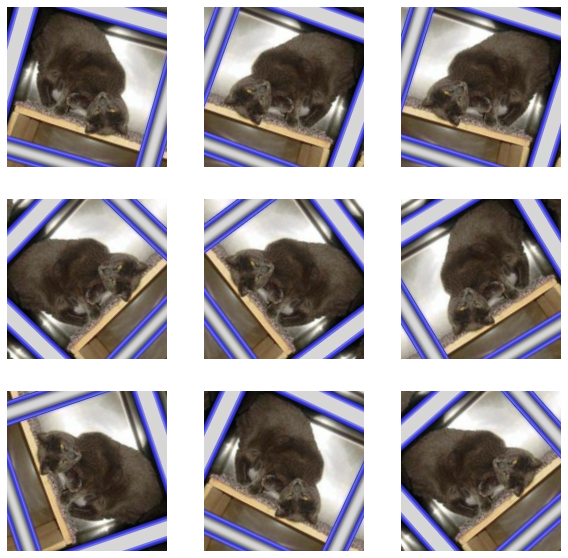

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [70]:
# Freeze the pre-trained model weights
base_model.trainable = True


# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = maxpool_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)



# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# Layer classification head with feature detector

inputs = tf.keras.layers.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = maxpool_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

learning_rate = 0.0001



# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
)

(32, 1280)
(32, 1)
Number of layers in the base model:  154


In [71]:
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_6 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_6 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_10 (Glo (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0  

In [44]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 10s 302ms/step - loss: 2.6795 - accuracy: 0.2784


In [45]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 2.89
initial accuracy: 0.26


In [46]:
# Start TensorBoard.

history= model.fit(train_dataset,  
          epochs=initial_epochs,
          validation_data=validation_dataset)  

Epoch 1/10
63/63 [==============================] - 51s 743ms/step - loss: 0.1503 - accuracy: 0.9450 - val_loss: 0.1253 - val_accuracy: 0.9715
Epoch 2/10
63/63 [==============================] - 49s 781ms/step - loss: 0.0674 - accuracy: 0.9820 - val_loss: 0.1747 - val_accuracy: 0.9666
Epoch 3/10
63/63 [==============================] - 61s 972ms/step - loss: 0.0323 - accuracy: 0.9890 - val_loss: 0.2880 - val_accuracy: 0.9493
Epoch 4/10
63/63 [==============================] - 59s 928ms/step - loss: 0.0385 - accuracy: 0.9890 - val_loss: 0.1685 - val_accuracy: 0.9765
Epoch 5/10
63/63 [==============================] - 55s 865ms/step - loss: 0.0618 - accuracy: 0.9885 - val_loss: 0.1652 - val_accuracy: 0.9740
Epoch 6/10
63/63 [==============================] - 53s 846ms/step - loss: 0.0424 - accuracy: 0.9880 - val_loss: 0.2052 - val_accuracy: 0.9715
Epoch 7/10
63/63 [==============================] - 57s 910ms/step - loss: 0.0410 - accuracy: 0.9915 - val_loss: 0.1866 - val_accuracy: 0.9765

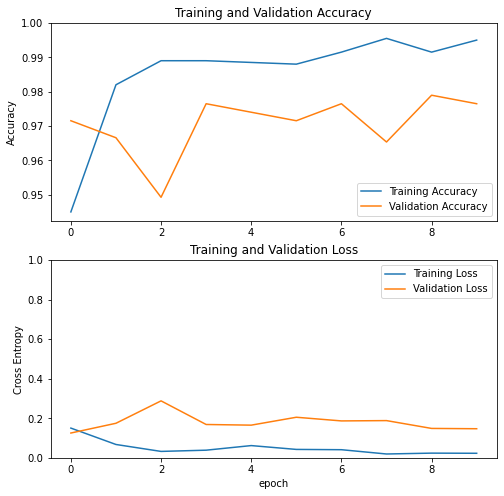

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [87]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)



6/6 [==============================] - 8s 395ms/step - loss: 1.8343 - accuracy: 0.5195
Test accuracy : 0.515625


Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Labels:
 [0 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1]


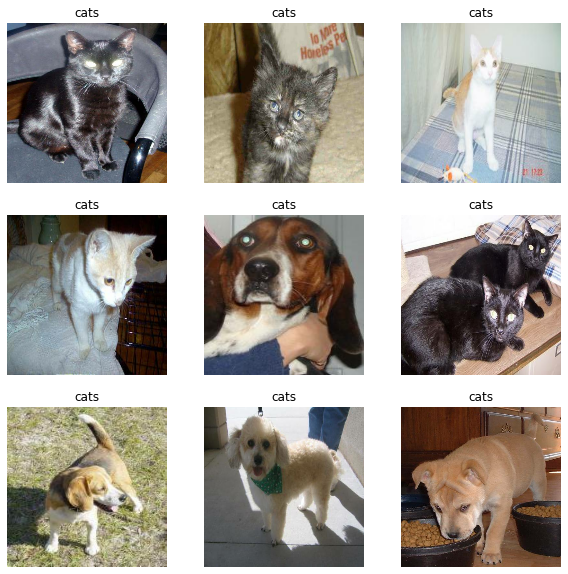

In [88]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


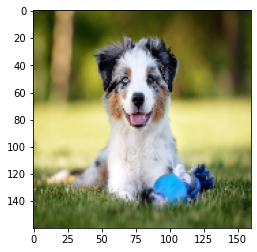

(1, 160, 160, 3)


In [91]:
#img_path = 'https://live.staticflickr.com/5504/14187029688_46e25edbf1_k.jpg'
img_path = 'https://www.jardiner-malin.fr/wp-content/uploads/2019/03/berger-australien-1.jpg'
im=urllib.request.urlretrieve(img_path, "sample.png")

img = tf.keras.preprocessing.image.load_img("sample.png", target_size=(160, 160))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [82]:
base_model.layers


In [84]:
layer_outputs = [layer.output for layer in base_model.layers] 
# Extracts the outputs of the top 12 
activation_model = models.Model(inputs=[base_model.input], outputs=layer_outputs) 
# Creates a model that will return these outputs, given the model input

In [92]:
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation

In [96]:
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

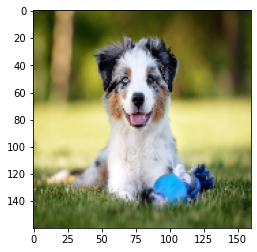

(1, 160, 160, 3)


In [115]:
#plt.imshow(img_tensor[0][:,:,0])
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

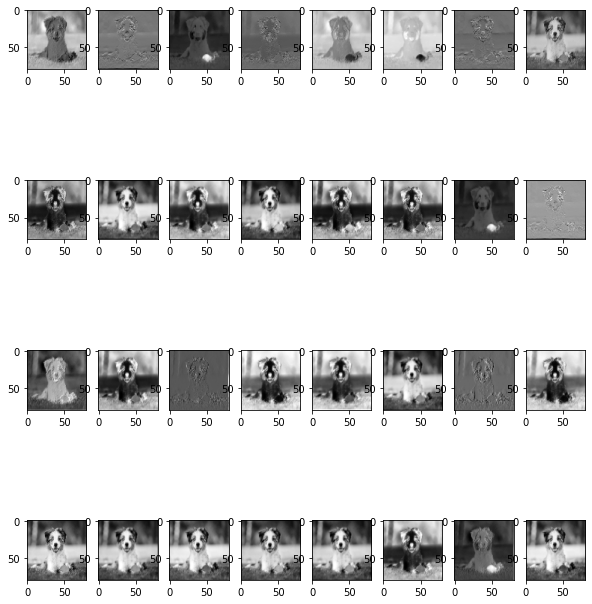

In [116]:
display_activation(activations, 8, 4, 1)

/home/marie/anaconda3/envs/example-environment/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/marie/anaconda3/envs/example-environment/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/marie/anaconda3/envs/example-environment/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


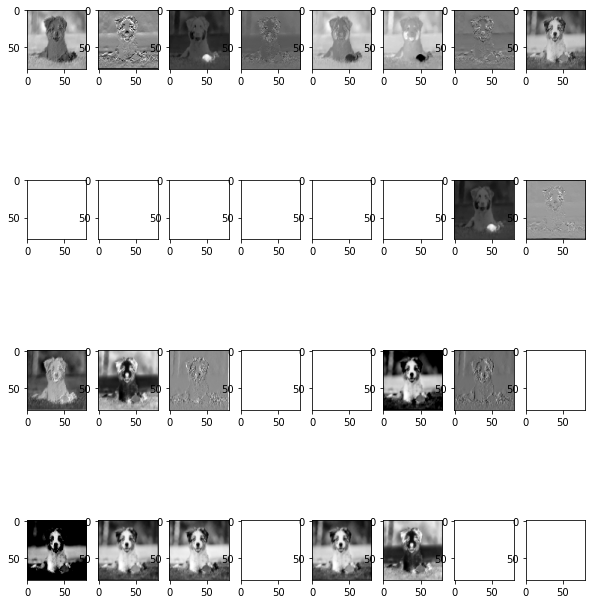

In [117]:
display_activation(activations, 8, 4, 3)


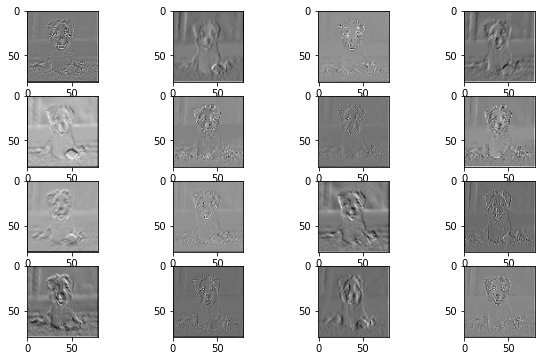

In [118]:
display_activation(activations, 4, 4, 7)


In [119]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 160, 160, 3)


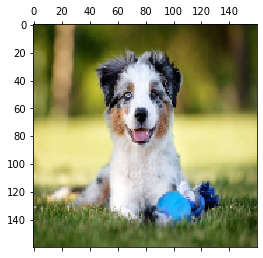

In [120]:
plt.matshow(first_layer_activation[0, :, :], cmap='viridis')

/home/marie/anaconda3/envs/example-environment/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


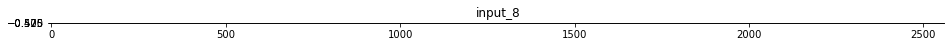

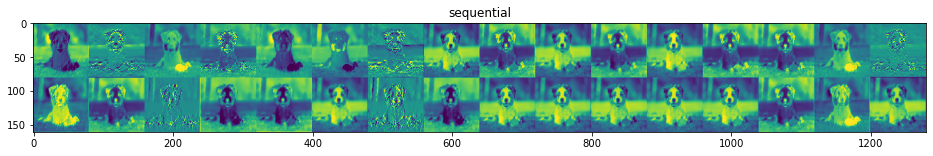

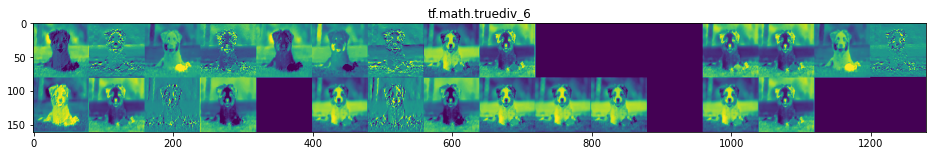

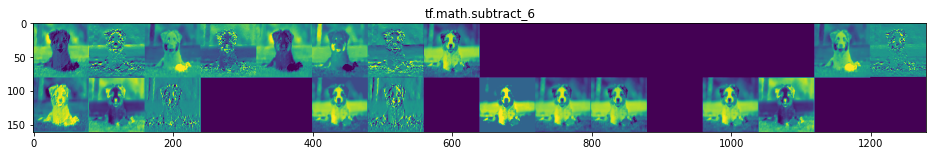

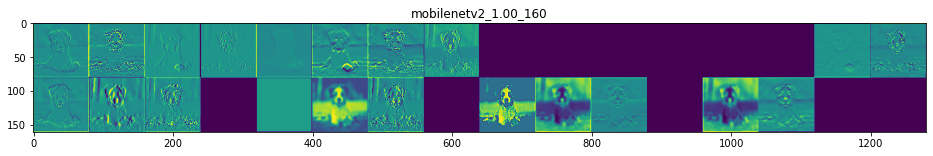

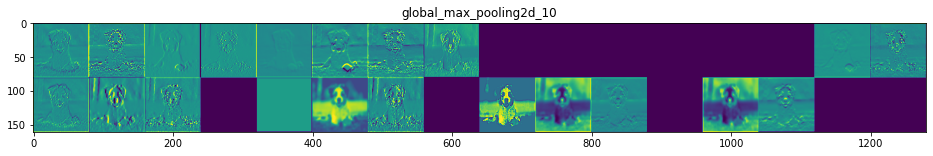

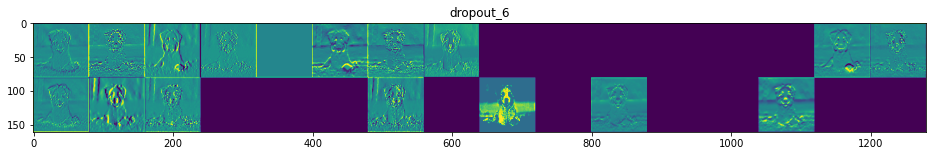

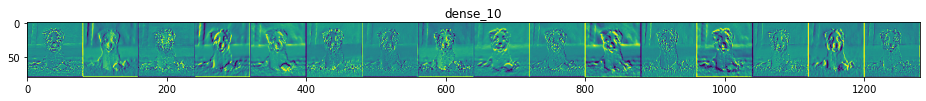

In [126]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')